In [2]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.lax import scan
from scipy.linalg import solve_discrete_are, norm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum, plot_optimization_results
from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process, filter_step_nonlinear
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix
import pickle 


key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
p = 2  # Observation dimension
J0 = 0 # burn in period
N = 10 # Monte Carlo samples for cost function sampling
F = 8.0
dt = 0.05
num_steps = 1000  # Number of time steps

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
Q = jnp.eye(n)* 0.1   # Process noise covariance matrix (Sigma in Julia code). We use diagonal for nonlinear case
H = jnp.eye(n)          # Observation noise matrix 
R = jnp.eye(H.shape[0])  # R is dependent on number of observed states (also written as Gamma)

observation_interval = 1

initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)

# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)


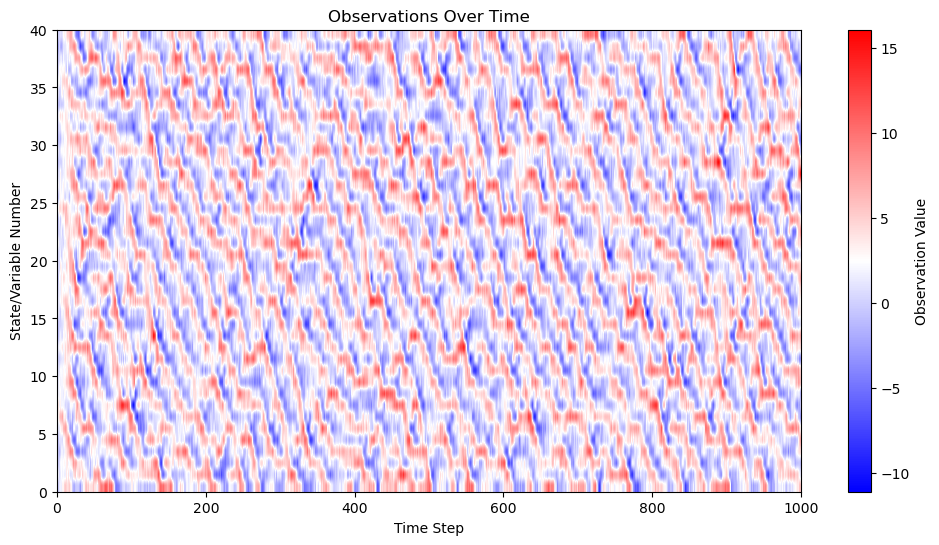

In [4]:
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
y = observations
visualize_observations(y)

In [3]:
@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, H, Q, R, y, key, num_steps, J0):
    m_preds, C_preds, m_updates, C_updates = apply_filtering_fixed_nonlinear(m0, C0, y, K, n, l96_step, jac_func, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(m_preds, C_preds, m_updates, C_updates, n, l96_step, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, m_updates, C_updates), y, H, R, num_steps, J0) 
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost

@partial(jit, static_argnums=(3))
def var_cost_single_step(K, m0, C0, n, Q, H, R, y_curr, key, J, J0):
    (m_update, C_update), _  =  filter_step_nonlinear((m0,C0), y_curr, K, n, l96_step, jac_func, H, Q, R)
    log_likelihood_val = log_likelihood(m_update[jnp.newaxis, :], y_curr[jnp.newaxis, :], H, R, J=1, J0=J0)
    # Calculate the KL divergence between the predicted and updated state distributions
    m_pred = state_transition_function(m0)
    M = jac_func(m0)
    C_pred = M @ C0 @ M.T + Q
    kl_divergence = KL_gaussian(n, m_update, C_update, m_pred, C_pred)
    # Combine the KL divergence and the negative log-likelihood to form the cost
    cost = kl_divergence - log_likelihood_val
    return cost


In [4]:
base_m, base_C, base_K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)
K_steady = jnp.mean(base_K[-50:, :, :], axis=0)

In [5]:
var_cost_grad = grad(var_cost, argnums=0)
# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.4

alpha = 1e-5

online = False
prediction_errors = [] 
norms = []
true_div = []
last_200_errors = []

n_iters = 100

for i in tqdm(range(n_iters)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, H, Q, R, y, key, num_steps, J0)
    K_opt -= alpha * grad_K
    
    # Apply filtering with the newly optimized K to generate state predictions
    _, _, predicted_states, covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K_opt, n, l96_step, jac_func, H, Q, R)
    
    prediction_error = jnp.mean(jnp.mean((predicted_states - true_states)**2, axis=1))
    prediction_errors.append(prediction_error)
    last_200_prediction_error = jnp.mean((predicted_states[-200:] - true_states[-200:])**2)
    last_200_errors.append(last_200_prediction_error)
    norms.append(norm(K_opt - K_steady))
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, predicted_states[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t 
    true_div.append(total_kl_divergence / num_steps)



data = {
    'norms': norms,
    'prediction_errors': prediction_errors,
    'true_div': true_div,
    'n_iters': n_iters,
    'K_steady': K_steady,
    'K_opt': K_opt
}
with open('fixed_nonlinear', 'wb') as f:
    pickle.dump(data, f)
    

  0%|          | 0/100 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>


In [6]:
#data = load_data('data.pkl')
# norms = data['norms']
# prediction_errors = data['prediction_errors']
# true_div = data['true_div']
# n_iters = data['n_iters']
# K_steady = data['K_steady']
# K_opt = data['K_opt']

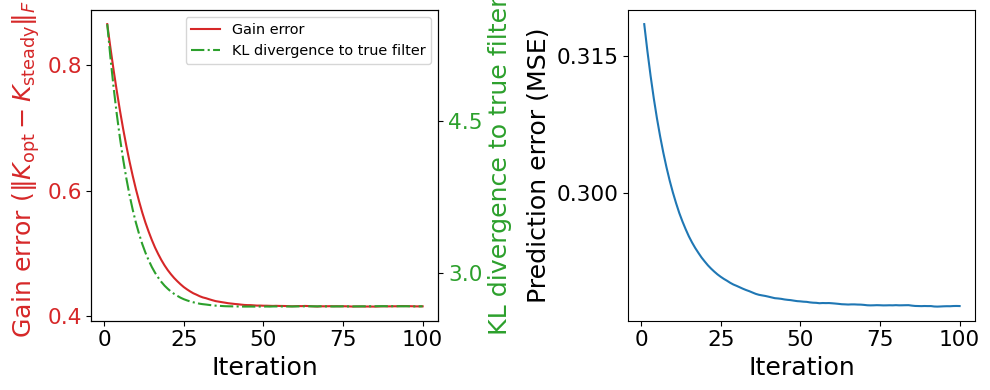

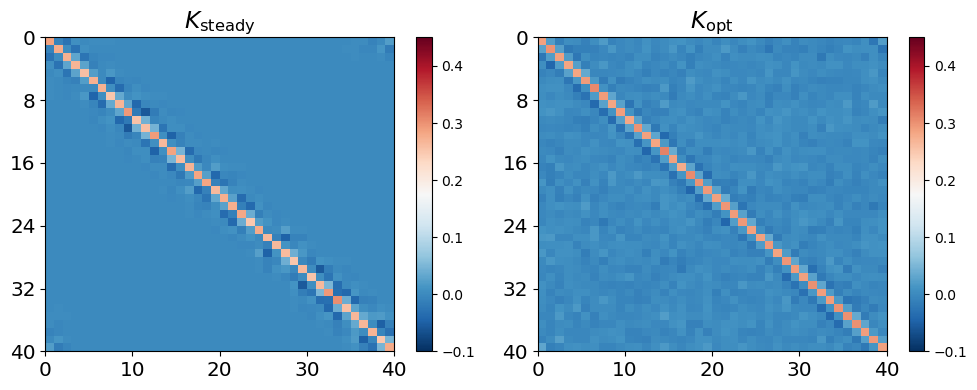

In [7]:
import pickle
with open('fixed_nonlinear', 'rb') as f:
    data = pickle.load(f)

online = False
norms = data['norms']
prediction_errors = data['prediction_errors']
true_div = data['true_div']
n_iters = data['n_iters']
K_steady = data['K_steady']
K_opt = data['K_opt']
import os
from jax_vi import plot_optimization_results, plot_k_matrices

subfolder_name = 'nonlinear_results'
file_base_name = "nonlinear_gain"

if online:
    n_iters = num_steps
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)

plot_optimization_results(norms, prediction_errors, true_div, n_iters, file_path, scaling=1.3, max_n_locator=3)

file_base_name = "nonlinear_gain_matrices"
if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)
plot_k_matrices(K_steady, K_opt, file_path, scaling=1.2, max_n_locator=5)

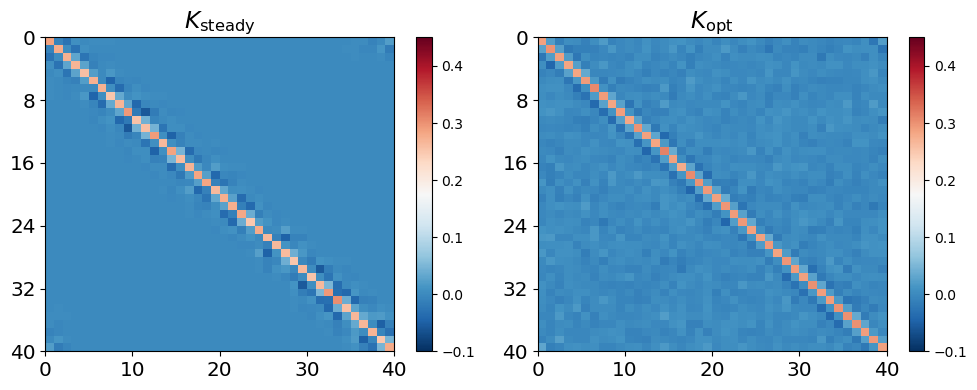

In [8]:
file_base_name = "nonlinear_gain_matrices"
if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)
plot_k_matrices(K_steady, K_opt, file_path)

In [16]:
prediction_errors[-1] #this is train error for final descent iteration

Array(0.2875766, dtype=float32)

In [11]:
# using a new random key and a new initialization to test out of distribution performance for learned gain


key = random.PRNGKey(42)
initial_state = random.normal(key, (n,))  # Initial state
test_observations, test_true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
y = test_observations
base_m, base_C, base_K = kalman_filter_process(l96_step, jac_func, m0, C0, test_observations, H, Q, R)


_, _, test_states, test_covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K_opt, n, l96_step, jac_func, H, Q, R)
prediction_error = jnp.mean(jnp.mean((test_states - test_true_states)**2, axis=1))
ekf_error = jnp.mean(jnp.mean((base_m - test_true_states)**2, axis=1))
print(f"Train Error for fixed gain: {prediction_errors[-1]:.4f}")
print(f"Test Error for fixed gain: {prediction_error:.4f}")
print(f"Extended KF Error: {ekf_error:.4f}")

Train Error for fixed gain: 0.2876
Test Error for fixed gain: 0.3155
Extended KF Error: 0.2713
